# Amazon Food Reviews - [SVM]

Data Source:https://www.kaggle.com/snap/amazon-fine-food-reviews

This dataset consists of reviews of fine foods from Amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

![alt text](http://nycdatascience.com/blog/wp-content/uploads/2016/04/NewCover.png)

## Excerpt 
1. Applied SVM with rbf(radial basis function) kernel on Different Featurization of Data viz. BOW(uni-gram,bi-gram), tfidf, Avg-Word2Vec(using Word2Vec model pretrained on Google News) and tf-idf-Word2Vec <br>
2. Used both Grid Search & Randomized Search Cross Validation <br>
3. Evaluated the test data on various performance metrics like accuracy, f1-score, precision, recall,etc. also plotted Confusion matrix using seaborne<br>
4. Evaluated SGDClassifier on the best resulting featurization

#### Data includes:
- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews

#### Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

![alt text](http://nycdatascience.com/blog/wp-content/uploads/2016/04/AmazonReview.png)


### Objective:- Review Polarity
Given a review, determine the review is positive or negative

#### Using text review to decide the polarity
Take the summary and text of review and analyze it using NLP whether the customer feedback/review is positive or negative


In [1]:
# # !pip install --upgrade pip
# # !pip install qtconsole ipywidgets widgetsnbextension
# # !pip install nltk
# # # import nltk
# # # nltk.download("stopwords")
# # !pip install seaborn
# # !pip install gensim
# !pip install sklearn-evaluation

In [2]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
from time import time
import random
import gensim
import warnings

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

warnings.filterwarnings("ignore")

%matplotlib inline 
# sets the backend of matplotlib to the 'inline' backend:
#With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook,
#directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

#Functions to save objects for later use and retireve it
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [28]:
# !wget --header="Host: e-2106e5ff6b.cognitiveclass.ai" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.99 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: _ga=GA1.2.1009651095.1527270727; _xsrf=2|d66eb8d7|8e30b1015ec501038d0632ff567bddb6|1529904261; session=.eJxVj9tugkAURX_FnGdi5FaBxKSgoiZKtYq0Ng0ZYIBRGBQGEY3_XjBt2r6us1f2PjdwjzhPEcWUgcbyEnOASha7LDtgCtoNOg3_gBoJaneSiIVh7x0UXf0wWsTyNNkZorCZKbm5Z6ZAgrAotpbZz3aC4fRn0vyqWFYujKlOp97YWF963kVdE10I-KoKzFLE7OS9rtUzNmRnPlrOlq6a6Updnh00TspafjLEGJ18aSjtfRu4Zo0HGsD9885BgRL2GNiilX18tye70-LNXLw4puw7vLzaWrWdxCN701OH0WAAjVQWOHcJDbPWxCkiSSPnxD_UKCCs-bLP889Ry7t-lgIHIckL5lKU4iaoPzINTdAvnJRH1rJ_mc4PbQu_L39r2i2V55IANEWWROn-BWX4gJ4.Dh-C7A.53fm96PBqDQvenTjy0oa1UWqE_8" --header="Connection: keep-alive" "https://e-2106e5ff6b.cognitiveclass.ai/files/Amazon%20Fine%20Food%20Reviews%20Dataset/tfidf_w2v_vec_google.p?download=1" -O "tfidf_w2v_vec_google.p" -c

### Loading the data

In [13]:
#Using sqlite3 to retrieve data from sqlite file

con = sql.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
df = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b'bought several vitality canned dog food prod...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...,b'product arrived labeled jumbo salted peanuts...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b'confection around centuries light pillowy ci...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b'looking secret ingredient robitussin believe...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b'great taffy great price wide assortment yumm...


In [14]:
df.describe()

,index,Id,HelpfulnessNumerator,HelpfulnessDenominator,Time
count,364171.000000,364171.000000,364171.000000,364171.000000,3.641710e+05
mean,241825.377603,261814.561014,1.739021,2.186841,1.296135e+09
std,154519.869452,166958.768333,6.723921,7.348482,4.864772e+07
min,0.000000,1.000000,0.000000,0.000000,9.393408e+08
25%,104427.500000,113379.500000,0.000000,0.000000,1.270858e+09
50%,230033.000000,249445.000000,0.000000,1.000000,1.311379e+09
75%,376763.500000,407408.500000,2.000000,2.000000,1.332893e+09
max,525813.000000,568454.000000,866.000000,878.000000,1.351210e+09


In [15]:
df.shape
df['Score'].size

364171

## For EDA and Text Preprecessing Refer other ipynb notebook<b>

In [16]:
#Score as positive/negative -> 0/1
def polarity(x):
    if x == "Positive":
        return 0
    else:
        return 1
df["Score"] = df["Score"].map(polarity) #Map all the scores as the function polarity i.e. positive or negative
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b'bought several vitality canned dog food prod...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...,b'product arrived labeled jumbo salted peanuts...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,0,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b'confection around centuries light pillowy ci...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,1,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b'looking secret ingredient robitussin believe...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,0,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b'great taffy great price wide assortment yumm...


In [17]:
#Taking Sample Data
n_samples = 25000
df_sample = df.sample(n_samples)

###Sorting as we want according to time series
df_sample.sort_values('Time',inplace=True) 
df_sample.head(10)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
169263,212454,230265,B00004RYGX,AZRJH4JFB59VC,Lynwood E. Hines,21,23,1,997228800,"Great movie, terrible DVD",I am continually amazed at the shoddy treatmen...,b'continu amaz shoddi treatment movi get dvd r...,b'continually amazed shoddy treatment movies g...
169255,212446,230257,B00004RYGX,A1OP3SQP78M1PP,James Gowen,0,0,0,1015718400,"A movie to ""literally die for!!!""",Beetlejuice is not a movie that you can't watc...,b'beetlejuic not movi cant watch time one funi...,b'beetlejuice not movie cant watch times one f...
316046,443662,479723,B00005U2FA,A3TO9GEQEGKFDC,"N. Smith ""emerald999""",35,35,0,1020211200,I love this thing,The wine saver is great in so many ways. Obvio...,b'wine saver great mani way obvious wonder abl...,b'wine saver great many ways obviously wonderf...
178946,226060,245108,B001O8NLV2,A356HBGSVZ5NRH,"B.P. ""tilley_traveler""",14,14,0,1038009600,Perpetually Delicious - Tazo Makes The Best!,"For me, when the days get colder nothing is as...",b'day get colder noth reward simpl cup hot tea...,b'days get colder nothing rewarding simple cup...
280071,388413,419994,B0000A0BS5,A238V1XTSK9NFE,Andrew Lynn,46,59,1,1064361600,Not actually for use in espresso machines,Few things I'd like to point out:<p>1. &quot;...,b'thing like point not roast drink northern it...,b'things like point not roast drink northern i...
55686,61299,66610,B0000SY9U4,A3EEDHNHI4WNSH,Joanna J. Young,23,23,0,1067472000,Yummy,"If you've never tried Kona coffee, Aloha Islan...",b'youv never tri kona coffe aloha island defin...,b'youve never tried kona coffee aloha island d...
36307,38888,42226,B0000A0BS8,A23GFTVIETX7DS,Debbie Lee Wesselmann,5,5,0,1067904000,Five stars if you like Starbucks,This blend is one of Starbucks' gentler blends...,b'blend one starbuck gentler blend like tast s...,b'blend one starbucks gentler blends like tast...
10496,10992,11991,B0000T15M8,A2928LJN5IISB4,chatchi,5,5,0,1067990400,The fruits of my labor,When chatchi's favorite afternoon treat became...,b'chatchi favorit afternoon treat becam myster...,b'chatchis favorite afternoon treat became mys...
199797,255320,276802,B0000DCXFY,AQFIH82DRPMW,Patrick O'Brien,5,5,0,1069027200,Great for Crostini,While Pesto Genovese is my favorite pesto for ...,b'pesto genoves favorit pesto capelli dang fam...,b'pesto genovese favorite pesto capelli dangel...
208301,267390,289844,B0000E5JRW,A12PEEUG7CN2BO,B. Kalafut,6,8,0,1069718400,The genuine article,Red beans and rice is such a simple dish. Eve...,b'red bean rice simpl dish everybodi new orlea...,b'red beans rice simple dish everybody new orl...


In [18]:
#Saving all samples in disk to as to test to test on the same sample for each of all Algo
savetofile(df_sample,"sample_svm")

In [3]:
#Opening from samples from file
df_sample = openfromfile("sample_svm")

# Support Vector Machine Model  using Different Featurization in NLP

![alt text](https://chrisalbon.com/images/machine_learning_flashcards/Support_Vector_Classifier_print.png)

## Bag of Words (BoW)

A commonly used model in methods of Text Classification. As part of the BOW model, a piece of text (sentence or a document) is represented as a bag or multiset of words, disregarding grammar and even word order and the frequency or occurrence of each word is used as a feature for training a classifier.<br>
OR <br>
Simply,Converting a collection of text documents to a matrix of token counts

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

#Text -> Uni gram Vectors
uni_gram = CountVectorizer() 
X_train = uni_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = uni_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (17500, 27066)
Test Data Size:  (7500, 27066)


In [7]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):
#     print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)

(1600, 27066) (1590, 27066)
(3190, 27066) (1590, 27066)
(4780, 27066) (1590, 27066)
(6370, 27066) (1590, 27066)
(7960, 27066) (1590, 27066)
(9550, 27066) (1590, 27066)
(11140, 27066) (1590, 27066)
(12730, 27066) (1590, 27066)
(14320, 27066) (1590, 27066)
(15910, 27066) (1590, 27066)


![i](https://i.stack.imgur.com/fXZ6k.png)

### Finding the best 'alpha' using Forward Chaining Cross Validation or Time Series CV 

In [8]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

clf = SVC()
param_grid = {'gamma':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,n_jobs=-1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.39 µs
Fitting 10 folds for each of 225 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed: 34.6min
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed: 59.6min
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed: 89.3min
[Parallel(n_jobs=-1)]: Done 1760 tasks      | elapsed: 114.9min
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed: 123.5min finished


Best HyperParameter:  {'C': 10, 'gamma': 0.5}
Best Accuracy: 90.30%


Accuracy on test set: 90.640%
Precision on test set: 0.800
Recall on test set: 0.622
F1-Score on test set: 0.700
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



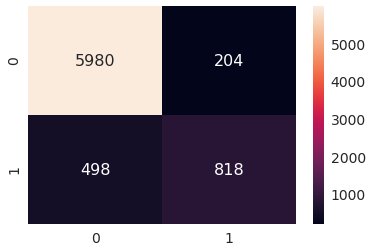

In [18]:
#Testing Accuracy on Test data
from sklearn.svm import SVC

clf = SVC(C=10,gamma=0.5)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Using Randomized Search CV to find best parameters

In [9]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import uniform as sp_rand

clf = SVC()
#params we need to try on classifier
param_dist = {'gamma':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_dist,cv=tscv,verbose=1,n_iter=15)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.39 µs
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 155.2min finished


Best HyperParameter:  {'gamma': 0.05, 'C': 50}
Best Accuracy: 89.96%


Accuracy on test set: 89.960%
Precision on test set: 0.756
Recall on test set: 0.632
F1-Score on test set: 0.688
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



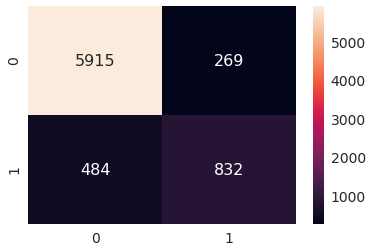

In [19]:
#Testing Accuracy on Test data
from sklearn.svm import SVC

clf = SVC(C=50,gamma=0.05)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### bi-gram

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

#taking one words and two consecutive words together
bi_gram = CountVectorizer() 
X_train = bi_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = bi_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (17500, 27066)
Test Data Size:  (7500, 27066)


In [11]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

clf = SVC()
param_grid = {'gamma':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,n_jobs=-1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs
Fitting 10 folds for each of 225 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed: 59.0min
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed: 88.7min
[Parallel(n_jobs=-1)]: Done 1760 tasks      | elapsed: 114.4min
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed: 123.3min finished


Best HyperParameter:  {'C': 10, 'gamma': 0.5}
Best Accuracy: 90.30%


Accuracy on test set: 90.640%
Precision on test set: 0.800
Recall on test set: 0.622
F1-Score on test set: 0.700
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



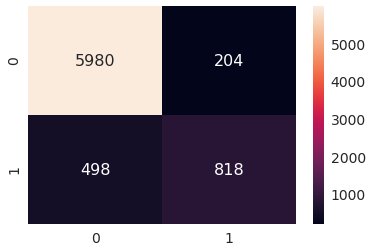

In [23]:
#Testing Accuracy on Test data
from sklearn.svm import SVC

clf = SVC(C=10,gamma=0.5)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Using Randomized Search CV to find best parameters

In [12]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import uniform as sp_rand

clf = SVC()
#params we need to try on classifier
param_dist = {'gamma':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_dist,cv=tscv,verbose=1,n_iter=15)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 126.9min finished


Best HyperParameter:  {'gamma': 0.5, 'C': 5}
Best Accuracy: 90.29%


Accuracy on test set: 90.707%
Precision on test set: 0.803
Recall on test set: 0.623
F1-Score on test set: 0.702
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



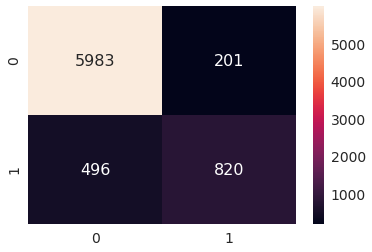

In [24]:
#Testing Accuracy on Test data
from sklearn.svm import SVC

clf = SVC(C=5,gamma=0.5)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# tf-idf


![alt text](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/01/11181616/image-4.png)

In [4]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams
X_train = tfidf.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (17500, 378093)
Test Data Size:  (7500, 378093)
CPU times: user 3.8 s, sys: 28 ms, total: 3.83 s
Wall time: 3.83 s


In [14]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

clf = SVC()
param_grid = {'gamma':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,n_jobs=-1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs
Fitting 10 folds for each of 225 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed: 72.6min
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed: 123.9min
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed: 180.8min
[Parallel(n_jobs=-1)]: Done 1760 tasks      | elapsed: 227.8min
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed: 241.7min finished


Best HyperParameter:  {'C': 1000, 'gamma': 0.005}
Best Accuracy: 89.87%


Accuracy on test set: 91.667%
Precision on test set: 0.838
Recall on test set: 0.651
F1-Score on test set: 0.733
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



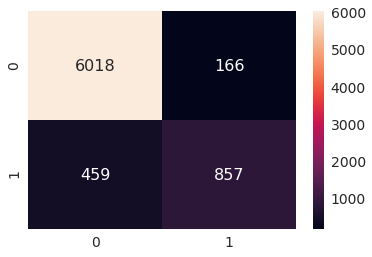

In [26]:
#Testing Accuracy on Test data
from sklearn.svm import SVC

clf = SVC(C=1000,gamma=0.005)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Using Randomized Search CV to find best parameters

In [15]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import uniform as sp_rand

clf = SVC()
#params we need to try on classifier
param_dist = {'gamma':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_dist,cv=tscv,verbose=1,n_iter=15)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.63 µs
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 327.5min finished


Best HyperParameter:  {'gamma': 0.01, 'C': 1000}
Best Accuracy: 89.86%


Accuracy on test set: 91.640%
Precision on test set: 0.837
Recall on test set: 0.650
F1-Score on test set: 0.732
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



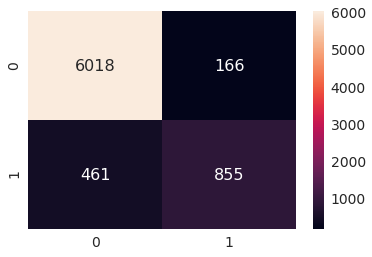

In [27]:
#Testing Accuracy on Test data
from sklearn.svm import SVC

clf = SVC(C=1000,gamma=0.01)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Using SGDClassifier with hinge loss

In [6]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import TimeSeriesSplit

clf = SGDClassifier()
#params we need to try on classifier
param_dist = {'penalty':['l1','l2','elasticnet'],
             'alpha':[500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_dist,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.6 µs
Fitting 10 folds for each of 48 candidates, totalling 480 fits
Best HyperParameter:  {'alpha': 1e-05, 'penalty': 'l1'}
Best Accuracy: 90.48%


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:   30.4s finished


Accuracy on test set: 91.040%
Precision on test set: 0.767
Recall on test set: 0.704
F1-Score on test set: 0.734
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



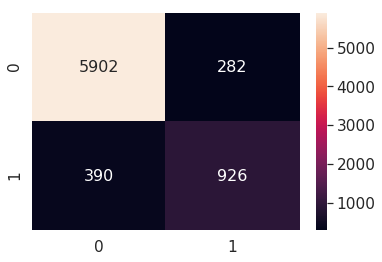

In [8]:
#Testing Accuracy on Test data
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(alpha=1e-05,penalty='l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Gensim
Gensim is a robust open-source vector space modeling and topic modeling toolkit implemented in Python. It uses NumPy, SciPy and optionally Cython for performance. Gensim is specifically designed to handle large text collections, using data streaming and efficient incremental algorithms, which differentiates it from most other scientific software packages that only target batch and in-memory processing.

## Word2Vec
[Refer Docs] :https://radimrehurek.com/gensim/models/word2vec.html 

In [28]:
from gensim.models import KeyedVectors

#Loading the model from file in the disk
w2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) 

In [29]:
w2v_vocub = w2vec_model.wv.vocab
len(w2v_vocub)

3000000

## Avg Word2Vec
* One of the most naive but good ways to convert a sentence into a vector
* Convert all the words to vectors and then just take the avg of the vectors the resulting vector represent the sentence 

In [30]:
%%time
avg_vec_google = [] #List to store all the avg w2vec's 
# no_datapoints = 364170
# sample_cols = random.sample(range(1, no_datapoints), 20001)
for sent in df_sample['CleanedText_NoStem']:
    cnt = 0 #to count no of words in each reviews
    sent_vec = np.zeros(300) #Initializing with zeroes
#     print("sent:",sent) 
    sent = sent.decode("utf-8") 
    for word in sent.split():
        try:
#             print(word)
            wvec = w2vec_model.wv[word] #Vector of each using w2v model
#             print("wvec:",wvec)
            sent_vec += wvec #Adding the vectors
#             print("sent_vec:",sent_vec)
            cnt += 1
        except: 
            pass #When the word is not in the dictionary then do nothing  
#     print(sent_vec)
    sent_vec /= cnt #Taking average of vectors sum of the particular review
#     print("avg_vec:",sent_vec)
    avg_vec_google.append(sent_vec) #Storing the avg w2vec's for each review
#     print("*******************************************************************")
# print(avg_vec_google)
avg_vec_google = np.array(avg_vec_google)

CPU times: user 11.9 s, sys: 40 ms, total: 11.9 s
Wall time: 11.9 s


In [31]:
np.isnan(avg_vec_google).any()

False

In [32]:
mask = ~np.any(np.isnan(avg_vec_google), axis=1)
# print(mask)
avg_vec_google_new = avg_vec_google[mask]
df_sample_new = df_sample['Score'][mask]
print(avg_vec_google_new.shape)
print(df_sample_new.shape)

(25000, 300)
(25000,)


In [33]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

avg_vec_norm = preprocessing.normalize(avg_vec_google_new)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(avg_vec_norm,df_sample_new.values,test_size=0.3,shuffle=False)

In [15]:
%time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

clf = SVC()
param_grid = {'gamma':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,n_jobs=-1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.82 µs
Fitting 10 folds for each of 225 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed: 57.5min
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed: 100.5min
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed: 150.8min
[Parallel(n_jobs=-1)]: Done 1760 tasks      | elapsed: 194.6min
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed: 211.4min finished


Best HyperParameter:  {'C': 5, 'gamma': 1}
Best Accuracy: 90.00%


Accuracy on test set: 89.573%
Precision on test set: 0.801
Recall on test set: 0.540
F1-Score on test set: 0.645
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



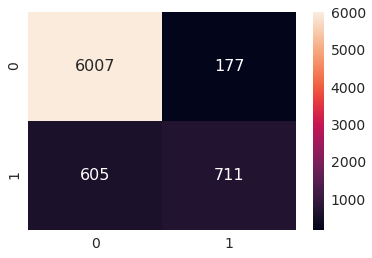

In [34]:
#Testing Accuracy on Test data
from sklearn.svm import SVC

clf = SVC(C=5,gamma=1)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Using Randomized Search CV to find best parameters

In [24]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import uniform as sp_rand

clf = SVC()
#params we need to try on classifier
param_dist = {'gamma':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_dist,cv=tscv,verbose=1,n_iter=15)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.34 µs
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 294.9min finished


Best HyperParameter:  {'gamma': 0.005, 'C': 500}
Best Accuracy: 89.19%


Accuracy on test set: 88.800%
Precision on test set: 0.786
Recall on test set: 0.497
F1-Score on test set: 0.609
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



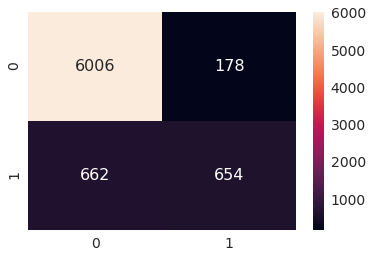

In [35]:
#Testing Accuracy on Test data
from sklearn.svm import SVC

clf = SVC(C=500,gamma=0.005)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Tf-idf W2Vec
* Another way to covert sentence into vectors
* Take weighted sum of the vectors divided by the sum of all the tfidf's 
<br>i.e. (tfidf(word) x w2v(word))/sum(tfidf's)

In [11]:
%%time
#Taking Sample Data as it was taking more that 10 hours to computer this block
n_samples = 25000
df_sample_new = df_sample.sample(n_samples)

###Sorting as we want according to time series
df_sample_new.sort_values('Time',inplace=True) 

###tf-idf with No Stemming
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams

tfidf_vec_new = tfidf.fit_transform(df_sample_new['CleanedText_NoStem'].values)

print(tfidf_vec_new.shape)

# tf-idf came up with 2.9 million features for the data corpus
# from sklearn.decomposition import TruncatedSVD

# tsvd_tfidf_ns = TruncatedSVD(n_components=300)#No of components as total dimensions
# tsvd_tfidf_vec_ns = tsvd_tfidf_ns.fit_transform(tfidf_vec_ns)
# print(tsvd_tfidf_ns.explained_variance_ratio_[:].sum())
features = tfidf.get_feature_names()

(25000, 589499)
CPU times: user 6.15 s, sys: 16 ms, total: 6.16 s
Wall time: 6.16 s


In [ ]:
%%time
tfidf_w2v_vec_google = []
review = 0

for sent in df_sample_new['CleanedText_NoStem'].values:
    cnt = 0 
    weighted_sum  = 0
    sent_vec = np.zeros(300)
    sent = sent.decode("utf-8") 
    for word in sent.split():
        try:
#             print(word)
            wvec = w2vec_model.wv[word] #Vector of each using w2v model
#             print("w2vec:",wvec)
#             print("tfidf:",tfidf_vec_ns[review,features.index(word)])
            tfidf_vec = tfidf_vec_new[review,features.index(word)]
            sent_vec += (wvec * tfidf_vec)
            weighted_sum += tfidf_vec
        except:
#             print(review)
            pass
    sent_vec /= weighted_sum
#     print(sent_vec)
    tfidf_w2v_vec_google.append(sent_vec)
    review += 1
tfidf_w2v_vec_google = np.array(tfidf_w2v_vec_google)
savetofile(tfidf_w2v_vec_google,"tfidf_w2v_vec_google")

In [2]:
#Precomputed File
tfidf_w2v_vec_google = openfromfile("tfidf_w2v_vec_google")
#Loading the same samples as using precomuted file
df_sample_new = openfromfile("df_sample_new_tfidfw2vec")

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

tfidfw2v_vecs_norm = preprocessing.normalize(tfidf_w2v_vec_google)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(tfidfw2v_vecs_norm,df_sample_new['Score'].values,test_size=0.3,shuffle=False)

In [8]:
%time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

clf = SVC()
param_grid = {'gamma':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,n_jobs=-1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.1 µs
Fitting 10 folds for each of 225 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed: 65.3min
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed: 112.6min
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed: 163.2min
[Parallel(n_jobs=-1)]: Done 1760 tasks      | elapsed: 214.0min
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed: 235.1min finished


Best HyperParameter:  {'C': 5, 'gamma': 0.5}
Best Accuracy: 88.08%


Accuracy on test set: 88.707%
Precision on test set: 0.777
Recall on test set: 0.421
F1-Score on test set: 0.546
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



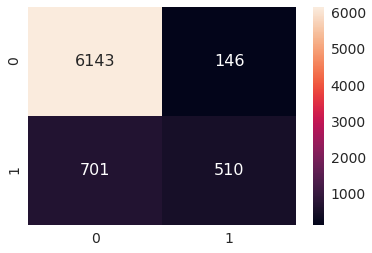

In [13]:
#Testing Accuracy on Test data
from sklearn.svm import SVC

clf = SVC(C=5,gamma=0.5)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Using Randomized Search CV to find best parameters

In [9]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

clf = SVC()
#params we need to try on classifier
param_dist = {'gamma':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_dist,cv=tscv,verbose=1,n_iter=15)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.63 µs
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 224.7min finished


Best HyperParameter:  {'gamma': 0.05, 'C': 1000}
Best Accuracy: 87.45%


Accuracy on test set: 88.840%
Precision on test set: 0.741
Recall on test set: 0.475
F1-Score on test set: 0.579
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



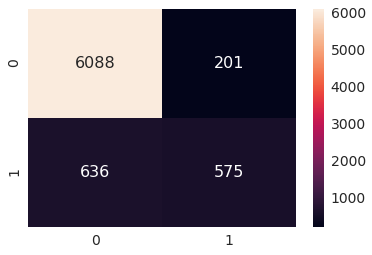

In [12]:
#Testing Accuracy on Test data
from sklearn.svm import SVC

clf = SVC(C=1000,gamma=0.05)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Performance Table

![image](https://image.ibb.co/mvrHz8/5_SVM.png)

## Conclusions<br>

1. Support Vector Machine(SVM) gave the best result better than other algos close to Logistic Regression
2. Tf-idf Featurization(C=1000,gamma=0.005) gave the best results with accuracy of 91.667% and F1-score of 0.733
3. SVM with RBF kernel the separating plane exists in another space - a result of kernel transformation of the original space. Its coefficients are not directly related to the input space. Hence we can't get the feature importance<br>
4. Also tried SGDClassifier with the best result i.e. with tfidf featurization it was very quick and gave around same score in just seconds with accuracy of 91.04% and F1-score of 0.734 with (alpha=1e-05,penalty='l1')